In [1]:
import numpy as np
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
# import sklearn

In [118]:
df_train = pd.read_csv('labelled_training_data.csv')
df_valid = pd.read_csv('labelled_validation_data.csv')
df_test = pd.read_csv('labelled_testing_data.csv')

In [60]:
# want to include but not included:
# timestamp, processName(but it probably means the same to processId, and might miss categories), args

def preprocess(df):
    # Provided by BETH author (Highman 2021)
    df_preprocessed = pd.DataFrame(df[['processId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'stackAddresses', 'returnValue']])

    # Process IDs: Map to 0 for OS processes, else 1
    df_preprocessed['processId'] = df['processId'].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS

    # Parent Process IDs: Map to 0 for OS processes, else 1
    df_preprocessed['parentProcessId'] = df['parentProcessId'].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS

    # User IDs: Map to 1 for users with IDs < 1000 (likely OS users), else 0
    df_preprocessed['userId'] = df['userId'].map(lambda x: 1 if x < 1000 else 0)  # Map to OS users

    # Namespace IDs: Check for specific value (402653184) for certain processes, else map to 0
    df_preprocessed['mountNamespace'] = df['mountNamespace'].map(lambda x: 0 if x == 402653184 else 1)  # Check for OS processes

    # Event IDs: Keep event IDs as is (assuming we need to know the maximum value) One-hot coding(?)
    df_preprocessed['eventId'] = df['eventId']

    # Convert the 'stackAddresses' string into a list of addresses
    df_preprocessed['stackAddresses'] = df['stackAddresses'].apply(lambda x: len(ast.literal_eval(x)) if x else 0)

    # Return Value: Map returnValue to 0 for 'failure', 1 for 'success', or 2 for unknown
    df_preprocessed['returnValue'] = df['returnValue'].map(lambda x: 0 if x == 0 else (1 if x == 1 else 2))

    return df_preprocessed

In [62]:
X_train = preprocess(df_train)
X_valid = preprocess(df_valid)
X_test = preprocess(df_test)

In [66]:
y_train = df_train['evil']
y_valid = df_valid['evil']
y_test = df_test['evil']

In [70]:
clf = IsolationForest(random_state = 10).fit(X_train)

In [72]:
score_valid = clf.decision_function(X_valid)
anomaly_valid = clf.predict(X_valid)

In [74]:
df_anomaly_valid = pd.DataFrame({'anomaly': anomaly_valid})
df_anomaly_valid['anomaly'] = df_anomaly_valid['anomaly'].apply(lambda x: 1 if x == -1 else 0)

In [76]:
cm_valid = confusion_matrix(y_valid, df_anomaly_valid['anomaly'])
print("Confusion Matrix:")
print(cm_valid)

Confusion Matrix:
[[146359  42608]
 [     0      0]]


In [78]:
# classification_report for precision, recall, F1-score, and accuracy
report = classification_report(y_valid, df_anomaly_valid['anomaly'])
print("Classification Report on Testing Data:")
print(report)

Classification Report on Testing Data:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87    188967
           1       0.00      0.00      0.00         0

    accuracy                           0.77    188967
   macro avg       0.50      0.39      0.44    188967
weighted avg       1.00      0.77      0.87    188967



C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [80]:
score_test = clf.decision_function(X_test)
anomaly_test = clf.predict(X_test)

In [82]:
df_anomaly_test = pd.DataFrame({'anomaly': anomaly_test})
df_anomaly_test['anomaly'] = df_anomaly_test['anomaly'].apply(lambda x: 1 if x == -1 else 0)

In [84]:
cm = confusion_matrix(y_test, df_anomaly_test['anomaly'])
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 18856  11679]
 [  9235 149197]]


In [86]:
# classification_report for precision, recall, F1-score, and accuracy
report = classification_report(y_test, df_anomaly_test['anomaly'])
print("Classification Report on Testing Data:")
print(report)

Classification Report on Testing Data:
              precision    recall  f1-score   support

           0       0.67      0.62      0.64     30535
           1       0.93      0.94      0.93    158432

    accuracy                           0.89    188967
   macro avg       0.80      0.78      0.79    188967
weighted avg       0.89      0.89      0.89    188967



ROC AUC score for Test Data: 0.21


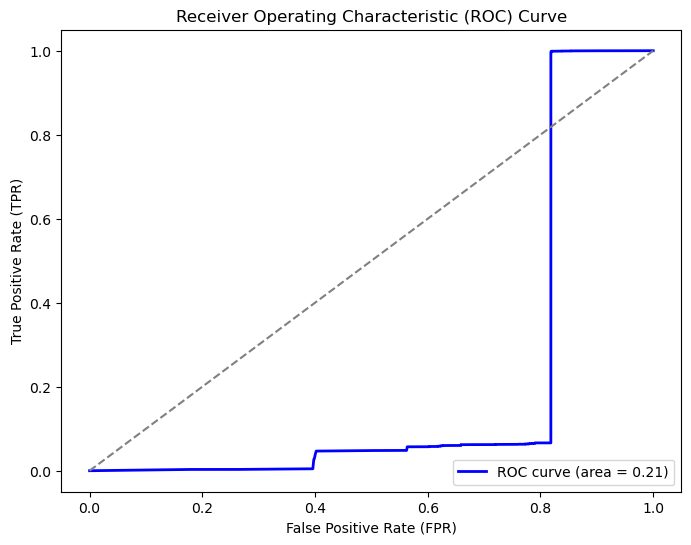

In [88]:
if len(np.unique(y_test)) > 1:
    # Compute ROC curve and ROC AUC score for test set
    fpr, tpr, thresholds = roc_curve(y_test, score_test)
    roc_auc = roc_auc_score(y_test, score_test)

    # Print the ROC AUC score
    print(f"ROC AUC score for Test Data: {roc_auc:.2f}")

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

else:
    print("Error: Only one class present in the test data. Cannot compute ROC AUC.")

Below is result without stackaddress

In [90]:
# want to include but not included:
# timestamp, processName(but it probably means the same to processId, and might miss categories), args

def preprocess(df):
    # Provided by BETH author (Highman 2021)
    df_preprocessed = pd.DataFrame(df[['processId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'returnValue']])

    # Process IDs: Map to 0 for OS processes, else 1
    df_preprocessed['processId'] = df['processId'].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS

    # Parent Process IDs: Map to 0 for OS processes, else 1
    df_preprocessed['parentProcessId'] = df['parentProcessId'].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS

    # User IDs: Map to 1 for users with IDs < 1000 (likely OS users), else 0
    df_preprocessed['userId'] = df['userId'].map(lambda x: 1 if x < 1000 else 0)  # Map to OS users

    # Namespace IDs: Check for specific value (402653184) for certain processes, else map to 0
    df_preprocessed['mountNamespace'] = df['mountNamespace'].map(lambda x: 0 if x == 402653184 else 1)  # Check for OS processes

    # Event IDs: Keep event IDs as is (assuming we need to know the maximum value) One-hot coding(?)
    df_preprocessed['eventId'] = df['eventId']

    # Return Value: Map returnValue to 0 for 'failure', 1 for 'success', or 2 for unknown
    df_preprocessed['returnValue'] = df['returnValue'].map(lambda x: 0 if x == 0 else (1 if x == 1 else 2))

    return df_preprocessed

In [94]:
X_train = preprocess(df_train)
X_valid = preprocess(df_valid)
X_test = preprocess(df_test)

In [95]:
y_train = df_train['evil']
y_valid = df_valid['evil']
y_test = df_test['evil']

In [98]:
clf = IsolationForest(random_state = 10).fit(X_train)

In [106]:
score = clf.decision_function(X_test)
anomaly = clf.predict(X_test)

In [108]:
type(anomaly)

numpy.ndarray

In [110]:
df_anomaly = pd.DataFrame({'anomaly': anomaly})
df_anomaly

,anomaly
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
188962,-1
188963,-1
188964,-1
188965,-1


In [112]:
df_anomaly['anomaly'] = df_anomaly['anomaly'].apply(lambda x: 1 if x == -1 else 0)
df_anomaly

,anomaly
0,1
1,1
2,1
3,1
4,1
...,...
188962,1
188963,1
188964,1
188965,1


In [114]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming 'anomaly' is the model's prediction and 'true_labels' is the ground truth
cm = confusion_matrix(df_test['evil'], df_anomaly['anomaly'])
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 19120  11415]
 [  9723 148709]]


In [116]:
report = classification_report(df_test['evil'], df_anomaly['anomaly'])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.63      0.64     30535
           1       0.93      0.94      0.93    158432

    accuracy                           0.89    188967
   macro avg       0.80      0.78      0.79    188967
weighted avg       0.89      0.89      0.89    188967

